In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline

In [2]:
conn=sqlite3.connect('C:/Users/SKS/Desktop/AAIC/database.sqlite')
filtered_data=pd.read_sql_query('''SELECT * FROM REVIEWS WHERE SCORE!=3''',conn)


In [3]:
filtered_data.Score=filtered_data.Score.apply(lambda x:'positive' if x>3 else 'negative')

In [4]:
sorted_values=filtered_data.sort_values('ProductId',axis=0,ascending=True)
final=sorted_values.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [5]:
final['Time']=pd.to_datetime(final['Time'])
final=final.sort_values(by='Time',ascending=True)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1970-01-01 00:00:00.944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1970-01-01 00:00:00.944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,1970-01-01 00:00:00.946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [6]:
final=final.iloc[:100000,:]

In [7]:
final.Score=final.Score.apply(lambda x:1 if x=='positive' else 0)

In [8]:
final.shape

(100000, 10)

# Text Preprocessing


In [9]:
import nltk
import re
def clean_html(sent):
    clean_text=re.sub(r"[<*.?>]",' ',sent)
    return clean_text

def clean_punc(sent):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sent)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

In [10]:
from tqdm import tqdm
import os

final_string=[]
for i,sent in enumerate(tqdm(final.Text.values)):
    filtered_sentence=[]
    sent=clean_html(sent)
    for w in sent.split():
        for word in clean_punc(w).split():
            if ((word.isalpha())&(len(word)>2)):
                if word.lower() not in stop:
                    s=(sno.stem(word.lower())).encode('utf-8')
                    filtered_sentence.append(s)
    string=b' '.join(filtered_sentence)
    final_string.append(string)

final['Cleaned_Text']=final_string
final['Cleaned_Text']=final['Cleaned_Text'].str.decode('utf-8')

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:30<00:00, 1108.20it/s]


In [11]:
from tqdm import tqdm
import os

final_string=[]
for i,sent in enumerate(tqdm(final.Summary.values)):
    filtered_sentence=[]
    sent=clean_html(sent)
    for w in sent.split():
        for word in clean_punc(w).split():
            if ((word.isalpha())&(len(word)>2)):
                if word.lower() not in stop:
                    s=(sno.stem(word.lower())).encode('utf-8')
                    filtered_sentence.append(s)
    string=b' '.join(filtered_sentence)
    final_string.append(string)

final['Cleaned_Summary']=final_string
final['Cleaned_Summary']=final['Cleaned_Summary'].str.decode('utf-8')

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:06<00:00, 15053.77it/s]


# Time Based Splitting

In [13]:
from sklearn.model_selection import train_test_split
X_train_text,X_test_text,y_train,y_test=train_test_split(final.Cleaned_Text,final.Score,test_size=0.30,shuffle=False)
X_train_summary,X_test_summary,y_train,y_test=train_test_split(final.Cleaned_Summary,final.Score,test_size=0.30,shuffle=False)

final.Score.value_counts()

1    87729
0    12271
Name: Score, dtype: int64

#### As we can see Our Data is Highly Imbalanced Positive class is far more than Negative Class

# Bag of Words Model

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
# Creating BOW for Text Column
cv_bow_text=CountVectorizer()
bow_X_train_text=cv_bow_text.fit_transform(X_train_text.values)
bow_X_test_text=cv_bow_text.transform(X_test_text.values)

In [15]:
# Creating BOW for Summary Column
cv_bow_summary=CountVectorizer(max_features=100,min_df=30)
bow_X_train_summary=cv_bow_summary.fit_transform(X_train_summary.values)
bow_X_test_summary=cv_bow_summary.transform(X_test_summary.values)

In [16]:
from scipy.sparse import hstack

bow_X_train=hstack([bow_X_train_text,bow_X_train_summary])
bow_X_test=hstack([bow_X_test_text,bow_X_test_summary])

In [17]:
from sklearn.preprocessing import StandardScaler
sc1=StandardScaler(with_mean=False)
bow_X_train=sc1.fit_transform(bow_X_train)
bow_X_test=sc1.transform(bow_X_test)

C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Logistic Regression with L2 Regularization

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [19]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

In [20]:
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(bow_X_train, y_train)
print(model.best_estimator_)
print('Training_ROC_AUC_Score-',model.best_score_)
print('Testing_ROC_AUC_Score-',model.score(bow_X_test, y_test))

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Training_ROC_AUC_Score- 0.905122090206
Testing_ROC_AUC_Score- 0.908793559472


#### Optimal value of C is 0.01

#### Testing ROC Score is 90.87%

#### Training and Testing ROC Scores are nearly same so, model is doing good job

### Accuracy Metrics 

In [21]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [22]:
classifier=LogisticRegression(C=0.01)
classifier.fit(bow_X_train,y_train)
pred_train=classifier.predict(bow_X_train)
pred_test=classifier.predict(bow_X_test)
accuracy_bow_train=accuracy_score(y_train,pred_train)*100
accuracy_bow_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_bow_train))
print("Testing Accuracy- {}%".format(accuracy_bow_test))
print("Training Error- {}%".format(100-accuracy_bow_train))
print("Testing Error- {}%".format(100-accuracy_bow_test))

Training Accuracy- 98.71571428571428%
Testing Accuracy- 91.41666666666667%
Training Error- 1.2842857142857156%
Testing Error- 8.583333333333329%


#### As both Training and Testing Error are low We can say that Our Model is doing Fine 

#### But we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 91.41%

### Classification Report 

In [23]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.71      0.63      0.67      4103
          1       0.94      0.96      0.95     25897

avg / total       0.91      0.91      0.91     30000



#### For Negative Reviews Recall is 0.63 or 63% which means out of all Actual Negative Points we are just predicting 63% of negative correctly which is bad while in Positive Reviews we are predicting 96% of Reviews as Positive out of all Actual Positive Reviews

#### F1 Score for Negative Review(0) is also low as compared to Positive Review(1)

### Confusion Matrix

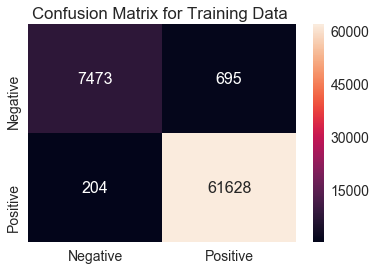

In [24]:
from sklearn.metrics import confusion_matrix,roc_curve
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

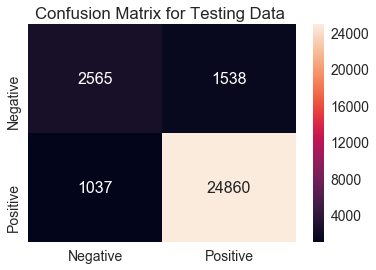

In [25]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### From Confusion Matrix We can see that we are predicting lot of negative reviews as positive 1538 negative reviews are predicted as positive

In [26]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR- {}".format(TPR))
print("FPR- {}".format(FPR))
print("TNR- {}".format(TNR))
print("FNR- {}".format(FNR))

TPR- 0.9417380104553376
FPR- 0.2878956135480289
TNR- 0.7121043864519712
FNR- 0.058261989544662475


### ROC AUC 

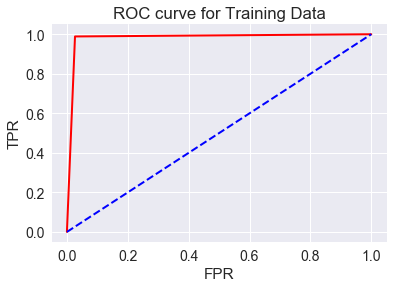

In [27]:
fpr, tpr,_=roc_curve(pred_train,y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Training Data')
plt.show()

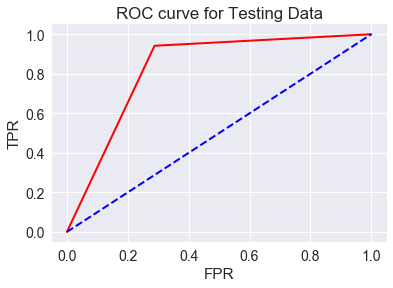

In [57]:
fpr, tpr,_=roc_curve(pred_test,y_test,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Testing Data')
plt.show()

# Perbutation Test by Percentile

In [29]:
w = classifier.coef_ #Weights of the classifier with original Data

In [30]:
import copy
bow_X_train_new=copy.deepcopy(bow_X_train)

In [31]:
e=np.random.normal(0,0.001)

In [32]:
bow_X_train_new.data=bow_X_train_new.data+e

In [33]:
classifier_new=LogisticRegression(C=0.01)

In [34]:
classifier_new.fit(bow_X_train_new,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
w_new= classifier_new.coef_ #Weights of the classifier after adding Noise

In [36]:
w=w+10**-6
w_new=w_new+10**-6

In [37]:
weight_difference=abs((w-w_new)/w)*100

In [38]:
weight_difference

array([[ 0.0052316 ,  0.00159869,  0.00862919, ...,  0.0029575 ,
         0.00257324,  0.00183551]])

In [39]:
print('10 Percentile-',np.percentile(weight_difference,10))  
print('20 Percentile-',np.percentile(weight_difference,20))   
print('50 Percentile-',np.percentile(weight_difference,50))   
print('80 Percentile-',np.percentile(weight_difference,80))   
print('90 Percentile-',np.percentile(weight_difference,90))  
print('95 Percentile-',np.percentile(weight_difference,95)) 
print('98 Percentile-',np.percentile(weight_difference,98))  
print('99 Percentile-',np.percentile(weight_difference,99))
print('99.1 Percentile-',np.percentile(weight_difference,99.1))
print('99.2 Percentile-',np.percentile(weight_difference,99.2)) 
print('99.3 Percentile-',np.percentile(weight_difference,99.3))
print('99.4 Percentile-',np.percentile(weight_difference,99.4)) 
print('99.5 Percentile-',np.percentile(weight_difference,99.5))
print('99.6 Percentile-',np.percentile(weight_difference,99.6))
print('99.7 Percentile-',np.percentile(weight_difference,99.7))
print('99.8 Percentile-',np.percentile(weight_difference,99.8)) 
print('99.9 Percentile-',np.percentile(weight_difference,99.9))
print('100 Percentile-',np.percentile(weight_difference,100)) 

10 Percentile- 0.00142338664405
20 Percentile- 0.00317638402326
50 Percentile- 0.0111629746077
80 Percentile- 0.0383515056002
90 Percentile- 0.0744772868421
95 Percentile- 0.160134162406
98 Percentile- 0.549135618117
99 Percentile- 1.7882999241
99.1 Percentile- 1.96861807487
99.2 Percentile- 2.58488681291
99.3 Percentile- 3.89932279792
99.4 Percentile- 28.9151760867
99.5 Percentile- 28.9151760867
99.6 Percentile- 96.8348259457
99.7 Percentile- 124.524166468
99.8 Percentile- 162.529672272
99.9 Percentile- 370.663963779
100 Percentile- 634507.853304


In [48]:
bow_features_text =cv_bow_text.get_feature_names()
bow_features_summary =cv_bow_summary.get_feature_names()
bow_features=bow_features_text+bow_features_summary
len(bow_features)

31479

In [41]:
index_colliner=np.where(weight_difference>28.9)[1]

In [42]:
print([bow_features[i] for i in index_colliner])

['acidolphilus', 'alanin', 'apex', 'ardor', 'arginin', 'aryl', 'bangladesh', 'beguil', 'bettuzzi', 'bifidobacgterium', 'bifidobacterium', 'biotin', 'brazen', 'brooklin', 'burgeon', 'burma', 'candlefish', 'cartlidg', 'cartlig', 'cellular', 'cervic', 'chaperon', 'chelat', 'chiap', 'christin', 'clair', 'colonoscopi', 'colposcopi', 'complicit', 'condensor', 'cooconut', 'counten', 'cowpi', 'curser', 'curtiss', 'cypress', 'cystin', 'dairymen', 'dairyperson', 'dairywomen', 'decenc', 'derang', 'diptheria', 'disarm', 'dsm', 'edam', 'epigallocatechingal', 'esophag', 'etruria', 'evermor', 'expector', 'experns', 'farmhand', 'fbop', 'fbopf', 'fleshier', 'fop', 'ftgfop', 'gale', 'gamma', 'garllic', 'gasiewicz', 'gbop', 'gfbop', 'gfop', 'glycin', 'gonif', 'haida', 'heedless', 'helpo', 'herceptin', 'histidin', 'hpv', 'huangshan', 'icebox', 'incess', 'inhomogen', 'inositol', 'intraepitheli', 'jaunti', 'kandi', 'kwakiutl', 'kyushu', 'laidlaw', 'lamington', 'laminin', 'leon', 'lifebit', 'liquamen', 'loam

# Perbutation Test by Elbow Method

In [43]:
per_change=list(range(1,101))

In [44]:
features_collinear=[]

In [45]:
for i in per_change:
    features_collinear.append(np.where(weight_difference>i)[1].size)

Text(0,0.5,'Collinear_Feature')

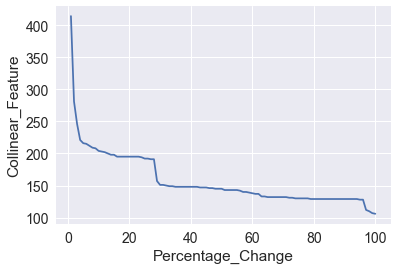

In [46]:
plt.plot(per_change,features_collinear)
plt.xlabel('Percentage_Change')
plt.ylabel('Collinear_Feature')

#### Change in Percentage near 29% so we choose 29% as threshold same as we got from Percentile Method

In [49]:
index_colliner=np.where(weight_difference>29)[1]

In [50]:
print([bow_features[i] for i in index_colliner])

['acidolphilus', 'alanin', 'apex', 'ardor', 'arginin', 'bangladesh', 'beguil', 'bifidobacgterium', 'bifidobacterium', 'biotin', 'brazen', 'brooklin', 'burgeon', 'burma', 'candlefish', 'cartlidg', 'cartlig', 'cellular', 'cervic', 'chelat', 'chiap', 'christin', 'complicit', 'condensor', 'cooconut', 'counten', 'cowpi', 'curser', 'curtiss', 'cypress', 'cystin', 'dairymen', 'dairyperson', 'dairywomen', 'decenc', 'derang', 'diptheria', 'disarm', 'edam', 'esophag', 'etruria', 'evermor', 'expector', 'experns', 'farmhand', 'fbop', 'fbopf', 'fleshier', 'fop', 'ftgfop', 'gale', 'gamma', 'garllic', 'gbop', 'gfbop', 'gfop', 'glycin', 'gonif', 'haida', 'heedless', 'helpo', 'histidin', 'huangshan', 'icebox', 'incess', 'inhomogen', 'inositol', 'jaunti', 'kandi', 'kwakiutl', 'laidlaw', 'lamington', 'leon', 'lifebit', 'liquamen', 'loami', 'machineri', 'mannerless', 'maofeng', 'mcg', 'medihoney', 'mepal', 'methionin', 'mgo', 'mien', 'moh', 'molan', 'monocl', 'montepulciano', 'monteverdi', 'myasthenia', '

# Sparsity Check

In [51]:
classifier_l2=LogisticRegression(C=0.1,penalty='l1')
classifier_l2.fit(bow_X_train,y_train)
w=classifier_l2.coef_
np.count_nonzero(w)

9003

In [52]:
classifier_l2=LogisticRegression(C=1,penalty='l1')
classifier_l2.fit(bow_X_train,y_train)
w=classifier_l2.coef_
np.count_nonzero(w)

11157

In [53]:
classifier_l2=LogisticRegression(C=10,penalty='l1')
classifier_l2.fit(bow_X_train,y_train)
w=classifier_l2.coef_
np.count_nonzero(w)

14110

In [54]:
classifier_l2=LogisticRegression(C=100,penalty='l1')
classifier_l2.fit(bow_X_train,y_train)
w=classifier_l2.coef_
np.count_nonzero(w)

14967

In [55]:
classifier_l2=LogisticRegression(C=1000,penalty='l1')
classifier_l2.fit(bow_X_train,y_train)
w=classifier_l2.coef_
np.count_nonzero(w)

23364

#### As we can see as C increases lambda decreases and Sparsity decreases as number of nonzero Weights are Increasing 

### Important Features

In [58]:
bow_features_text =cv_bow_text.get_feature_names()
bow_features_summary =cv_bow_summary.get_feature_names()
bow_features=bow_features_text+bow_features_summary
weights= classifier.coef_
feature_weights = pd.DataFrame(weights, columns = bow_features)
feature_weights=feature_weights.T
feature_weights.head()

,0
aaa,-4.521972e-10
aaaaaaaaagghh,2.277853e-03
aaaaah,6.975769e-03
aaaaahhhhhhhhhhhhhhhh,2.216436e-07
aaaah,-1.178140e-09


In [59]:
feature_weights.shape

(31479, 1)

#### Important Features for Negative Review

In [60]:
feature_weights[0].sort_values(ascending = True)[0:10]

disappoint   -0.341746
worst        -0.334126
terribl      -0.245462
stale        -0.237329
unfortun     -0.230405
aw           -0.230035
disappoint   -0.217091
tast         -0.201360
horribl      -0.199995
bland        -0.194583
Name: 0, dtype: float64

#### Important Features for Positive Review

In [61]:
feature_weights[0].sort_values(ascending = False)[0:10]

great     0.708729
great     0.676909
best      0.587950
best      0.530476
love      0.527170
love      0.490341
excel     0.465414
delici    0.459678
yummi     0.439738
good      0.413213
Name: 0, dtype: float64

# TF-IDF Model

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
#TFIDF for Text 
tfidf_vect_text=TfidfVectorizer()
tfidf_X_train_text=tfidf_vect_text.fit_transform(X_train_text.values)
tfidf_X_test_text=tfidf_vect_text.transform(X_test_text.values)

#TFIDF for Summary
tfidf_vect_summary=TfidfVectorizer(max_features=100)
tfidf_X_train_summary=tfidf_vect_summary.fit_transform(X_train_summary.values)
tfidf_X_test_summary=tfidf_vect_summary.transform(X_test_summary.values)

from scipy.sparse import hstack

tfidf_X_train=hstack([tfidf_X_train_text,tfidf_X_train_summary])
tfidf_X_test=hstack([tfidf_X_test_text,tfidf_X_test_summary])

from sklearn.preprocessing import StandardScaler
sc1=StandardScaler(with_mean=False)
tfidf_X_train=sc1.fit_transform(tfidf_X_train)
tfidf_X_test=sc1.transform(tfidf_X_test)

# Logistic Regression with L2 Regularization

In [63]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

In [104]:
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(tfidf_X_train, y_train)

print(model.best_estimator_)
print('Training_ROC_AUC_Score-',model.best_score_)
print('Testing_ROC_AUC_Score-',model.score(tfidf_X_test, y_test))


LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Training_ROC_AUC_Score- 0.927184266348
Testing_ROC_AUC_Score- 0.932014273045


#### Optimal Value of C is 0.0001

#### Testing ROC Score is 93.20%

#### Training and Testing ROC Scores are nearly same so, model is doing good job

### Accuracy Metrics 

In [105]:
classifier=model.best_estimator_
classifier.fit(tfidf_X_train,y_train)
pred_train=classifier.predict(tfidf_X_train)
pred_test=classifier.predict(tfidf_X_test)
accuracy_tfidf_train=accuracy_score(y_train,pred_train)*100
accuracy_tfidf_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_tfidf_train))
print("Testing Accuracy- {}%".format(accuracy_tfidf_test))
print("Training Error- {}%".format(100-accuracy_tfidf_train))
print("Testing Error- {}%".format(100-accuracy_tfidf_test))


Training Accuracy- 95.4557142857143%
Testing Accuracy- 90.30333333333334%
Training Error- 4.5442857142857065%
Testing Error- 9.696666666666658%


#### As both Training and Testing Error are low We can say that Our Model is doing Fine 

#### But we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 90.30%

In [106]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.83      0.37      0.51      4103
          1       0.91      0.99      0.95     25897

avg / total       0.90      0.90      0.89     30000



#### For Negative Reviews Recall is 0.37 or 37% which means out of all Actual Negative Points we are just predicting 13% of negative correctly which is bad while in Positive Reviews we are predicting 99% of Reviews as Positive out of all Actual Positive Reviews

#### F1 Score for Negative Review(0) is also very low

#### Model through TFIDF is predicting most of the Points as Positive reveiws as recall for negative review is very low

### Confusion Matrix

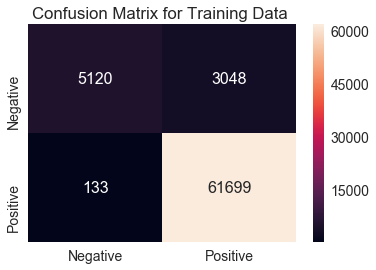

In [107]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

#### For Training Data TFIDF model is doing a great job as True Negative and True Positives are very high

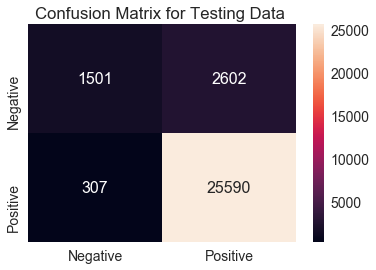

In [108]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### From Confusion Matrix We can see that we are predicted more Negetive Reviews as Postive Reviews than Negative Reviews as Negative Reviews i.e. Out of 4098 Negative reviews we are predicting 2602 reviews as Positive so model from tfidf is predicing more false positives

#### TFIDF Model is predicting more False Positive with respect to BOW Model

In [109]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR-{}".format(TPR))
print("FPR-{}".format(FPR))
print("TNR-{}".format(TNR))
print("FNR-{}".format(FNR))

TPR-0.9077043132803633
FPR-0.1698008849557522
TNR-0.8301991150442478
FNR-0.09229568671963678


### ROC AUC 

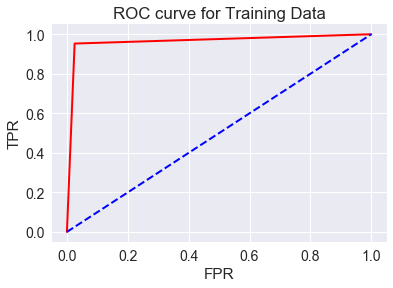

In [110]:
fpr, tpr,_=roc_curve(pred_train,y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Training Data')
plt.show()

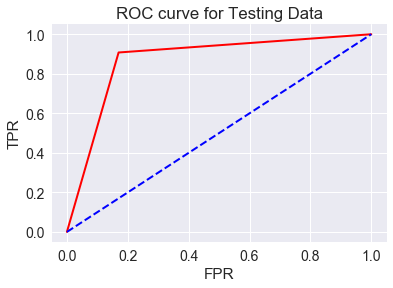

In [111]:
fpr, tpr,_=roc_curve(pred_test,y_test,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Testing Data')
plt.show()

In [112]:
tfidf_features_text =tfidf_vect_text.get_feature_names()
tfidf_features_summary =tfidf_vect_summary.get_feature_names()
tfidf_features=tfidf_features_text+tfidf_features_summary
weights= classifier.coef_
feature_weights = pd.DataFrame(weights, columns = tfidf_features)
feature_weights=feature_weights.T
feature_weights.head()

,0
aaa,0.000375
aaaaaaaaagghh,0.001149
aaaaah,0.001929
aaaaahhhhhhhhhhhhhhhh,0.000641
aaaah,0.000409


#### Important Features for Negative Review

In [113]:
feature_weights[0].sort_values(ascending = True)[0:10]

disappoint   -0.091298
disappoint   -0.082809
worst        -0.072214
aw           -0.062702
terribl      -0.062264
horribl      -0.057186
stale        -0.052704
return       -0.051947
wast         -0.050630
bland        -0.050328
Name: 0, dtype: float64

#### Important Features for Positive Review

In [114]:
feature_weights[0].sort_values(ascending = False)[0:10]

great     0.151963
love      0.129566
great     0.120111
best      0.108394
good      0.102881
best      0.093600
delici    0.085832
love      0.083290
good      0.072863
excel     0.072393
Name: 0, dtype: float64

# Average Word2Vec Model

In [115]:
from gensim.models import Word2Vec
# Train Data for Text
list_of_sent_train_text=[]
for sent in X_train_text.values:
    list_of_sent_train_text.append(sent.split())
w2v_model_text=Word2Vec(list_of_sent_train_text,min_count=5,size=50, workers=4)
w2v_words_text = list(w2v_model_text.wv.vocab)
sent_vectors_train_text = []
for sent in tqdm(list_of_sent_train_text): 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent:
        if word in w2v_words_text:
            vec = w2v_model_text.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train_text.append(sent_vec)

# Test Data for Text
list_of_sent_test_text=[]
for sent in X_test_text.values:
    list_of_sent_test_text.append(sent.split())
sent_vectors_test_text = []
for sent in tqdm(list_of_sent_test_text): 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent:
        if word in w2v_words_text:
            vec = w2v_model_text.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test_text.append(sent_vec) 

#Train data for Summary
list_of_sent_train_summary=[]
for sent in X_train_summary.values:
    list_of_sent_train_summary.append(sent.split())
w2v_model_summary=Word2Vec(list_of_sent_train_summary,min_count=5,size=50, workers=4)
w2v_words_summary = list(w2v_model_summary.wv.vocab)
sent_vectors_train_summary = []
for sent in tqdm(list_of_sent_train_summary): 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent:
        if word in w2v_words_summary:
            vec = w2v_model_summary.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train_summary.append(sent_vec)

#Test data for Summary
list_of_sent_test_summary=[]
for sent in X_test_summary.values:
    list_of_sent_test_summary.append(sent.split())
sent_vectors_test_summary = []
for sent in tqdm(list_of_sent_test_summary): 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent:
        if word in w2v_words_summary:
            vec = w2v_model_summary.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test_summary.append(sent_vec) 

100%|█████████████████████████████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 16978.88it/s]


In [116]:
sent_vectors_train_text=np.array(sent_vectors_train_text)
sent_vectors_test_text=np.array(sent_vectors_test_text)
sent_vectors_train_summary=np.array(sent_vectors_train_summary)
sent_vectors_test_summary=np.array(sent_vectors_test_summary)

In [117]:
sent_vectors_train=np.hstack((sent_vectors_train_text,sent_vectors_train_summary))
sent_vectors_test=np.hstack((sent_vectors_test_text,sent_vectors_test_summary))

In [118]:
sent_vectors_train.shape

(70000, 100)

In [119]:
from sklearn.preprocessing import StandardScaler
sc1=StandardScaler(with_mean=False)
sent_vectors_train=sc1.fit_transform(sent_vectors_train)
sent_vectors_test=sc1.transform(sent_vectors_test)

# Logistic Regression with L2 Regularization

In [120]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

In [122]:
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(sent_vectors_train, y_train)

print(model.best_estimator_)
print('Training_ROC_AUC_Score-',model.best_score_)
print('Testing_ROC_AUC_Score-',model.score(sent_vectors_test, y_test))


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Training_ROC_AUC_Score- 0.915999276814
Testing_ROC_AUC_Score- 0.922020295422


#### Optimal Value of C is 1

#### Testing ROC Score is 92.20%

#### Training and Testing ROC Scores are nearly same so, model is doing good job

In [123]:
classifier=model.best_estimator_
classifier.fit(sent_vectors_train,y_train)
pred_train=classifier.predict(sent_vectors_train)
pred_test=classifier.predict(sent_vectors_test)
accuracy_tfidf_train=accuracy_score(y_train,pred_train)*100
accuracy_tfidf_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_tfidf_train))
print("Testing Accuracy- {}%".format(accuracy_tfidf_test))
print("Training Error- {}%".format(100-accuracy_tfidf_train))
print("Testing Error- {}%".format(100-accuracy_tfidf_test))


Training Accuracy- 91.60142857142857%
Testing Accuracy- 90.55333333333333%
Training Error- 8.39857142857143%
Testing Error- 9.446666666666673%


#### As both Training and Testing Error are low We can say that Our Model is doing Fine 

#### But we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 90.55%

In [124]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.75      0.46      0.57      4103
          1       0.92      0.98      0.95     25897

avg / total       0.90      0.91      0.90     30000



#### For Negative Reviews Recall is 0.46 or 46% which means out of all Actual Negative Points we are just predicting 46% of negative correctly which is bad while in Positive Reviews we are predicting 98% of Reviews as Positive out of all Actual Positive Reviews

#### F1 Score for Negative Review(0) is also low

### Confusion Matrix

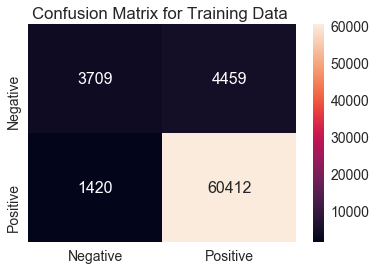

In [125]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

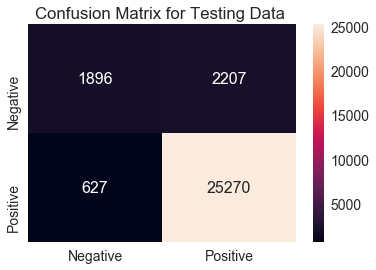

In [126]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### From Confusion Matrix We can see that we are predicting lot of negative reviews as positive 2207 negative reviews are predicted as positive

In [127]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR-{}".format(TPR))
print("FPR-{}".format(FPR))
print("TNR-{}".format(TNR))
print("FNR-{}".format(FNR))

TPR-0.9196782763766059
FPR-0.24851367419738407
TNR-0.751486325802616
FNR-0.08032172362339411


### ROC AUC 

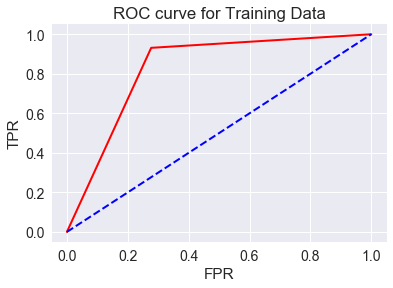

In [128]:
fpr, tpr,_=roc_curve(pred_train,y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Training Data')
plt.show()

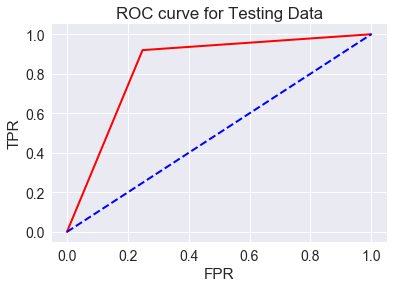

In [129]:
fpr, tpr,_=roc_curve(pred_test,y_test,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Testing Data')
plt.show()

#### As Area under the Red Curve is mostly same for Training and Testing data which says Our model is good

# TFIDF Word2Vec Model

In [130]:
model_text = TfidfVectorizer()
tf_idf_matrix_text = model_text.fit_transform(X_train_text.values)

dictionary = dict(zip(model_text.get_feature_names(), list(model_text.idf_)))

tfidf_feat_text = model_text.get_feature_names() 
tfidf_sent_vectors_train_text = []
for sent in tqdm(list_of_sent_train_text): 
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        if (word in w2v_words_text):
            vec = w2v_model_text.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train_text.append(sent_vec)
    
tf_idf_matrix_text = model_text.transform(X_test_text.values)

dictionary = dict(zip(model_text.get_feature_names(), list(model_text.idf_)))

tfidf_feat_text = model_text.get_feature_names() 
tfidf_sent_vectors_test_text = []
for sent in tqdm(list_of_sent_test_text): 
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        if (word in w2v_words_text):
            vec = w2v_model_text.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test_text.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:49<00:00, 607.73it/s]


In [131]:
from sklearn.preprocessing import StandardScaler
sc1=StandardScaler(with_mean=False)
tfidf_sent_vectors_train_text=sc1.fit_transform(tfidf_sent_vectors_train_text)
tfidf_sent_vectors_test_text=sc1.transform(tfidf_sent_vectors_test_text)

# Logistic Regression with L2 Regularization

In [132]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

In [133]:
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(tfidf_sent_vectors_train_text, y_train)

print(model.best_estimator_)
print('Training_ROC_AUC_Score-',model.best_score_)
print('Testing_ROC_AUC_Score-',model.score(tfidf_sent_vectors_test_text, y_test))


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Training_ROC_AUC_Score- 0.867177010289
Testing_ROC_AUC_Score- 0.873654387098


#### Optimal value of C is 0.01

In [141]:
classifier=model.best_estimator_
classifier.fit(tfidf_sent_vectors_train_text,y_train)
pred_train=classifier.predict(tfidf_sent_vectors_train_text)
pred_test=classifier.predict(tfidf_sent_vectors_test_text)
accuracy_tfidf_train=accuracy_score(y_train,pred_train)*100
accuracy_tfidf_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_tfidf_train))
print("Testing Accuracy- {}%".format(accuracy_tfidf_test))
print("Training Error- {}%".format(100-accuracy_tfidf_train))
print("Testing Error- {}%".format(100-accuracy_tfidf_test))


Training Accuracy- 89.75714285714285%
Testing Accuracy- 88.29666666666667%
Training Error- 10.242857142857147%
Testing Error- 11.703333333333333%


#### As both Training and Testing Error are low We can say that Our Model is doing Fine 

#### But we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 88.29%

In [135]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.69      0.26      0.38      4103
          1       0.89      0.98      0.94     25897

avg / total       0.87      0.88      0.86     30000



#### For Negative Reviews Recall is 0.26 or 26% which means out of all Actual Negative Points we are just predicting 26% of negative correctly which is bad while in Positive Reviews we are predicting 98% of Reviews as Positive out of all Actual Positive Reviews

#### F1 Score for Negative Review(0) is also low

### Confusion Matrix

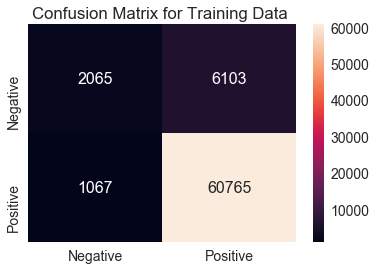

In [136]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

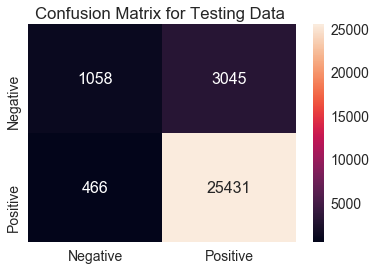

In [137]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### From Confusion Matrix We can see that we are predicting lot of negative reviews as positive 3045 negative reviews are predicted as positive

In [138]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR-{}".format(TPR))
print("FPR-{}".format(FPR))
print("TNR-{}".format(TNR))
print("FNR-{}".format(FNR))

TPR-0.8930678466076696
FPR-0.30577427821522307
TNR-0.6942257217847769
FNR-0.10693215339233038


### ROC AUC 

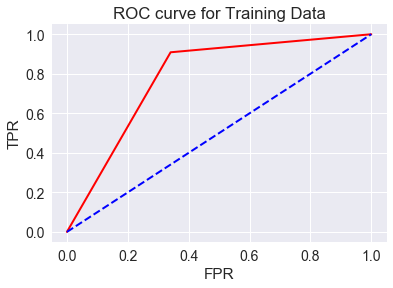

In [139]:
fpr, tpr,_=roc_curve(pred_train,y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Training Data')
plt.show()

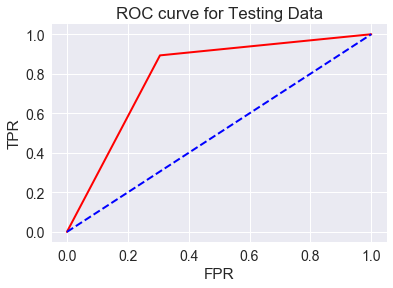

In [140]:
fpr, tpr,_=roc_curve(pred_test,y_test,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Testing Data')
plt.show()

# Conclusions

* From Above Analysis we can say BOW model is best for Amazaon Food Review data set 
* Accuracy can't be the best measure for this dataset as it is highly imabalanced
* As TFIDF model have best ROC_AUC score but its Recall for Negative Reviews is very less as compared to BOW Model
* BOW Model is Predicting less False Positives with respect to all other Models
* We Choose 29% Weight Difference Percentage as Thresold for getting Multicollinear Features
* Sparcity Decreases as we Increase Value of C